<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
!nvidia-smi
!nvcc -V

Thu Feb 23 08:28:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8     9W /  80W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [3]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [4]:
# Basic python libraries.
import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
import seaborn as sns

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries.

from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD

print('Above libraries have been imported.')

Above libraries have been imported.


**Seperate the Training and Validation Data.**

In [5]:
tf.__version__

'2.11.0'

In [10]:
# Define the train and validataion data paths.
train_dir = '../Dataset/train'
val_dir = '../Dataset/test'

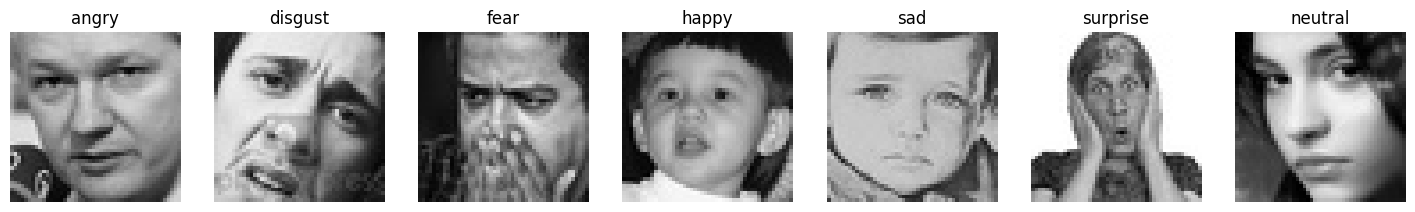

In [11]:
# Define the default image size.
img_size = 48

# Define the seven emotions provided in dataset.
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Plot the images with each distinct emotions.
plt.figure(figsize=(18,22))
i = 1
for expression in emotion_list:
    img = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[59]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

**Have a look at our data.**

**Perform some Data Augmentation on train and validations sets.**

# **Data Preprocessing:**

In [12]:
# Rescale the data.
'''
Before we proceed we need to rescale our data by multiplying it to 1/255.
This is done so we get target values between 0 and 1.
'''
# Rescale train data.
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale validation data.
datagen_val = ImageDataGenerator(rescale = 1./255,
                                 )

print('Above data generator functions have been created.')

Above data generator functions have been created.


In [13]:
# Perform data augmentation.
'''
Data augmentation is a technique to artificially create new training data from existing training data. 
It helps us to increase the size of the dataset and introduce variability in the dataset.
'''
# Define the default image size.
img_size = 48

# Define batch size.
batch_size = 64

                                         
# Train data
train_set = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation data
val_set = datagen_train.flow_from_directory(
    directory=val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


print('Train and Validation sets have been created.')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train and Validation sets have been created.


**Now lets create our custom CNN model.**

# **Build CNN Model:**

**Before we start building the neural network lets understand some of the terms that we will be using.**

* **Model = sequential** : A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

* **Padding** = The padding parameter of the Keras Conv2D class can take one of two values: 'valid' or 'same'. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

* **Activation** = relu :The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

* **Maxpooling** = Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling.

* **Batch normalization** = Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

* **Dropout** = Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

* **Adam** = Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [14]:
# AlexNet model

class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()
    self.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    self.add(MaxPooling2D((2, 2)))
    self.add(Conv2D(64, (3, 3), activation='relu'))
    self.add(MaxPooling2D((2, 2)))
    self.add(Conv2D(128, (3, 3), activation='relu'))
    self.add(MaxPooling2D((2, 2)))
    self.add(Flatten())
    self.add(Dense(128, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))

    opt = SGD(lr=0.01)
    self.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
class VGGNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
    self.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    self.add(MaxPooling2D(pool_size=(2, 2)))

    self.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    self.add(MaxPooling2D(pool_size=(2, 2)))

    self.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    self.add(MaxPooling2D(pool_size=(2, 2)))

    self.add(Flatten())
    self.add(Dense(4096, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(4096, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(1000, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01)
    self.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    self.summary()
    


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define ResNet building blocks
def identity_block(x, filters):
    # Save input tensor
    x_shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    
    # Add shortcut to output and apply ReLU activation
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def convolutional_block(x, filters, strides):
    # Save input tensor
    x_shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, (3, 3), padding='same', strides=strides)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    
    # Apply 1x1 convolution to shortcut connection
    x_shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(x_shortcut)
    
    # Add shortcut to output and apply ReLU activation
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def ResNet(input_shape=(48, 48, 3), num_classes=7):
    # Define input tensor
    x_input = Input(input_shape)
    
    # Zero-padding layer
    x = ZeroPadding2D((3, 3))(x_input)
    
    # Initial convolutional layer and max pooling
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    # ResNet blocks
    x = convolutional_block(x, 64, strides=(2, 2))
    x = identity_block(x, 64)

    x = convolutional_block(x, 128, strides=(2, 2))
    x = identity_block(x, 128)

    x = convolutional_block(x, 256, strides=(2, 2))
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    
    # Global average pooling and fully connected layer
    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    x = Dropout(0.1)(x)
    # Create the model
    model = Model(inputs=x_input, outputs=x, name='ResNet')
    opt = SGD(lr=0.005, clipnorm=1.0)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model



In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

# Define model architecture
model_AlexNet = AlexNet((48,48,3), 7)
model_VGGNet = VGGNet((48,48,3), 7)
model_ResNet = ResNet()
    
# Load weights model
model_AlexNet.load_weights('../weights/AlexNet_weighs_iters150.h5')
model_VGGNet.load_weights('../weights/VGGNetcus_weights_100iters.h5')
model_ResNet.load_weights('../weights/resNetcus_model_weighs-50iters.h5')

alexnet_preds = model_AlexNet.predict(val_set)
vggnet_preds = model_VGGNet.predict(val_set)
resnet_preds = model_ResNet.predict(val_set)


# Concatenate the predictions
combined_pred = np.concatenate((alexnet_preds, vggnet_preds, resnet_preds), axis=1)

svm_model = SVC(kernel='linear')
svm_model.fit(combined_pred, val_set.classes)
    
    

Model: "vgg_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 48, 48, 64)        1792      
                                                                 
 conv2d_108 (Conv2D)         (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_110 (Conv2D)         (None, 12, 12, 256)       29

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 54, 54, 3)   0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_111 (Conv2D)            (None, 54, 54, 64)   1792        ['zero_padding2d_4[0][0]']       
                                                                                                  
 batch_normalization_64 (BatchN  (None, 54, 54, 64)  256         ['conv2d_111[0][0]']        

                                                                  'activation_70[0][0]']          
                                                                                                  
 activation_72 (Activation)     (None, 14, 14, 128)  0           ['add_33[0][0]']                 
                                                                                                  
 conv2d_122 (Conv2D)            (None, 7, 7, 256)    295168      ['activation_72[0][0]']          
                                                                                                  
 batch_normalization_73 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_122[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 7, 7, 256)    0           ['batch_normalization_73[0][0]'] 
          

2023-02-27 08:52:31.310082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/113 [..............................] - ETA: 3s 

2023-02-27 08:52:36.159937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 7s 60ms/step


2023-02-27 08:52:43.249614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 10s 90ms/step


SVC(kernel='linear')

#Save model

In [23]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(svm_model,f)


# **Model evaluation:**

In [26]:
# Convert the validation data labels to numeric labels
y_true = val_set.classes

# Convert the SVM predictions to numeric labels
y_pred = svm_model.predict(combined_pred)

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.657286152131513


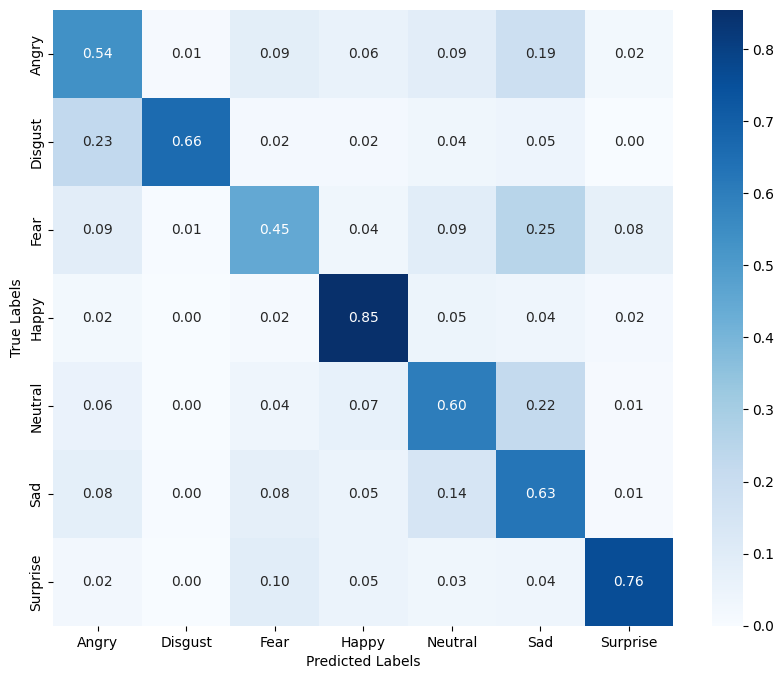

In [27]:

label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert the values to ratios
cm_ratios = cm / cm.sum(axis=1, keepdims=True)

# Create a plot of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ratios, annot=True, cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values(), fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Load model and predict

In [ ]:
from tensorflow.keras.preprocessing import image

# Load the SVM model
with open('model.pkl', 'rb') as f:
    svm_loaded = pickle.load(f)

# Load and preprocess the test image
img = image.load_img("sad1.png", target_size=(48, 48))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)
    
# Obtain predictions from the pre-trained models
alexnet_pred = model_AlexNet.predict(img)
vggnet_pred = model_VGGNet.predict(img)
resnet_pred = model_ResNet.predict(img)
    
# Concatenate the predictions
combined_pred = np.concatenate((alexnet_pred, vggnet_pred, resnet_pred), axis=1)
    
    
# Use the SVM model to predict the class label
    
svm_pred = svm_loaded.predict(combined_pred)
    
predicted_label = label_dict[svm_pred[0]]
print(predicted_label)